In [1]:
import numpy as np 
import pandas as pd 
import os 
from tqdm import tqdm, trange

import matplotlib.pyplot as plt 
import plotly.express as px 
from IPython.display import Audio

import librosa

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence

In [2]:
class PATHS : 
    root_path = '/kaggle/input/'
    competition_path = os.path.join(root_path, 'birdclef-2024')
    enhanced_path = os.path.join(root_path, 'enhanced-birdclef-metadata')
    train_audio = os.path.join(competition_path, 'train_audio')
    unlabeled_soundscapes = os.path.join(competition_path, 'unlabeled_soundscapes')

sample_submission = pd.read_csv(os.path.join(PATHS.competition_path, "sample_submission.csv"))
taxonomy = pd.read_csv(os.path.join(PATHS.competition_path, "eBird_Taxonomy_v2021.csv"))
train_metadata = pd.read_csv(os.path.join(PATHS.enhanced_path, "enhanced_metadata.csv"))

# Encoding primary_label as numerical label 
NUM_CATEGORIES = train_metadata.primary_label.nunique()
labels = train_metadata.primary_label.unique()
train_metadata['nlabel'] = train_metadata.primary_label.map(dict(zip(labels, range(len(labels)))))

#NOTE : Need to fix csv file to remove index column
train_metadata = train_metadata.drop(columns=['Unnamed: 0'])

In [3]:
def get_spectrogram(filepath:str, window_duration=25, offset=0.0, duration=None, pad=True) : 
    """
    Generates a mel spectrogram from an audio file.
    
    filepath: local path in train_audio/ directory to audio file.
    window_duration: Length of STFT window, in seconds
    """
    # Retrieving and loading data
    data, sr = librosa.load(os.path.join(PATHS.train_audio, filepath), offset=offset, duration=duration)
    
    # Padding to desired duration
    if pad and ((sample_dur := librosa.get_duration(y=data, sr=sr)) < duration) : 
        data = np.append(data, np.zeros(int((duration - sample_dur) * sr)))
    
    # Defining n_samples for stft
    n_samples = window_duration * 1e-3 * sr
    n_samples_rounded = 2 ** int(np.log(n_samples) / np.log(2)) # convert to power of 2 for FFT
    stft = librosa.stft(data, n_fft=n_samples_rounded)

    # Computing mel spectrogram 
    specmag, _ = librosa.magphase(stft)
    melspec = librosa.feature.melspectrogram(S=specmag, sr=sr)
    melspec = librosa.amplitude_to_db(melspec, ref=np.min)
    
    return melspec

def augment_spectrogram(spectrogram, normalize=True, translation=False, max_noise=0.0) : 
    """
    Augments spectrogram data by randomly translating and adding noise.
    """
    
    if normalize : 
        spectrogram = (spectrogram - spectrogram.mean())/spectrogram.std()
    
    # Random translation
    if translation : 
        spectrogram = np.roll(spectrogram, np.random.randint(spectrogram.shape[1]), axis=1)
        
    if max_noise : 
        spectrogram = spectrogram + np.random.random() * max_noise * spectrogram.max() * np.random.random(spectrogram.shape)
    
    return spectrogram

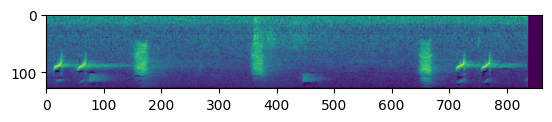

In [4]:
window_size = 5.0
idx = 1001

n_samples = np.ceil((train_metadata.duration / window_size)).cumsum()

audio_idx = np.where(n_samples >= idx+1)[0].min()
audio_path = os.path.join(PATHS.train_audio, train_metadata.filename[audio_idx])

i = int(idx - ([0.0] + n_samples.to_list())[audio_idx])
sample = augment_spectrogram(get_spectrogram(audio_path, offset=i*window_size, duration=window_size))

plt.imshow(sample)

In [ ]:
class BirdCLEFDataset(Dataset) : 
    def __init__(self, metadata: pd.DataFrame, window_size=5.0) : 
        self.metadata = metadata
        self.window_size = window_size
        
        # Get cumulative number of samples per recording
        self.n_samples = np.ceil((self.metadata.duration / self.window_size)).cumsum()
        
    def __len__(self) : 
        return int(self.n_samples.sum())
    
    def __getitem__(self, idx) : 
        
        # Find which recording the idx corresponds to
        data_loc = np.where(self.n_samples >= idx+1)[0].min()
        audio_path = os.path.join(PATHS.train_audio, self.metadata.filename.iloc[data_loc])
        
        # Get location within recording
        i = int(idx - ([0.0] + self.n_samples.to_list())[data_loc])
        
        # Load sample
        sample = augment_spectrogram(get_spectrogram(audio_path, offset=i*self.window_size, duration=self.window_size))
        X = torch.Tensor(sample)
        
        # Get label
        nlabel = self.metadata.nlabel.iloc[data_loc]
        y = F.one_hot(torch.as_tensor(nlabel), num_classes=NUM_CATEGORIES).type(torch.float32)
        
        return X, y 

#def collate_fn(batch):
#    spectrograms_T = [item[0].T for item in batch]
#    labels = torch.stack([item[1] for item in batch]).type(torch.float32)
#    padded_spectrograms = torch.swapaxes(pad_sequence(spectrograms_T, batch_first=True, padding_value=0.0), 1, 2)
#    return padded_spectrograms, labels    
    
dataset = BirdCLEFDataset(train_metadata[train_metadata.rating >= 2.5])
train_data, val_data = random_split(dataset, [0.8, 0.2])

train_dataloader = DataLoader(train_data, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=1)

In [ ]:
X, y = train_dataloader.__getitem__(5)

In [6]:
class CNN_RNN(nn.Module):
    def __init__(self, num_classes, cnn_out_channels, rnn_hidden_size, rnn_num_layers):
        super(CNN_RNN, self).__init__()

        # 1D CNN to extract features from spectrograms
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=128, out_channels=cnn_out_channels, kernel_size=30, stride=10),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5)
        )

        # RNN to process sequential features
        self.rnn = nn.GRU(input_size=cnn_out_channels, hidden_size=rnn_hidden_size, num_layers=rnn_num_layers, batch_first=True)

        # Final linear layer for classification
        self.fc = nn.Linear(rnn_hidden_size, num_classes)

    def forward(self, x):
        # x: batch of spectrograms (batch_size, height, width)
        batch_size, height, width = x.shape

        # Extract features using CNN
        features = self.cnn(x)

        # Reshape features for RNN (batch_size, seq_len, features)
        features = torch.swapaxes(features, 1, 2)

        # Process sequential features using RNN
        h0 = torch.zeros(self.rnn.num_layers, batch_size, self.rnn.hidden_size).to(x.device)
        out, _ = self.rnn(features, h0)

        # Get the last hidden state for classification
        out = out[:, -1, :]

        # Final linear layer for classification
        out = F.log_softmax(self.fc(out), dim=1)

        return out

In [10]:
# Define model and loss criterion
model = CNN_RNN(NUM_CATEGORIES, 32, 64, 1)
criterion = nn.CrossEntropyLoss()

# Send to device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# Train the model
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
for epoch in range(10):  # 10 epochs
    for X, y in (pbar := tqdm(train_dataloader)):
        X, y = X.to(device), y.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(X)
        # Compute the loss
        loss = criterion(outputs, y)
        # Backward pass
        loss.backward()
        # Update the model parameters
        optimizer.step()
        
        pbar.set_description(f'Epoch {epoch+1}, Loss: {loss.item():.2f}')

Epoch 2, Loss: 5.407794952392578:   0%|          | 28/18028 [00:04<44:59,  6.67it/s] 


KeyboardInterrupt: 

In [105]:
X, y = next(iter(train_dataloader))

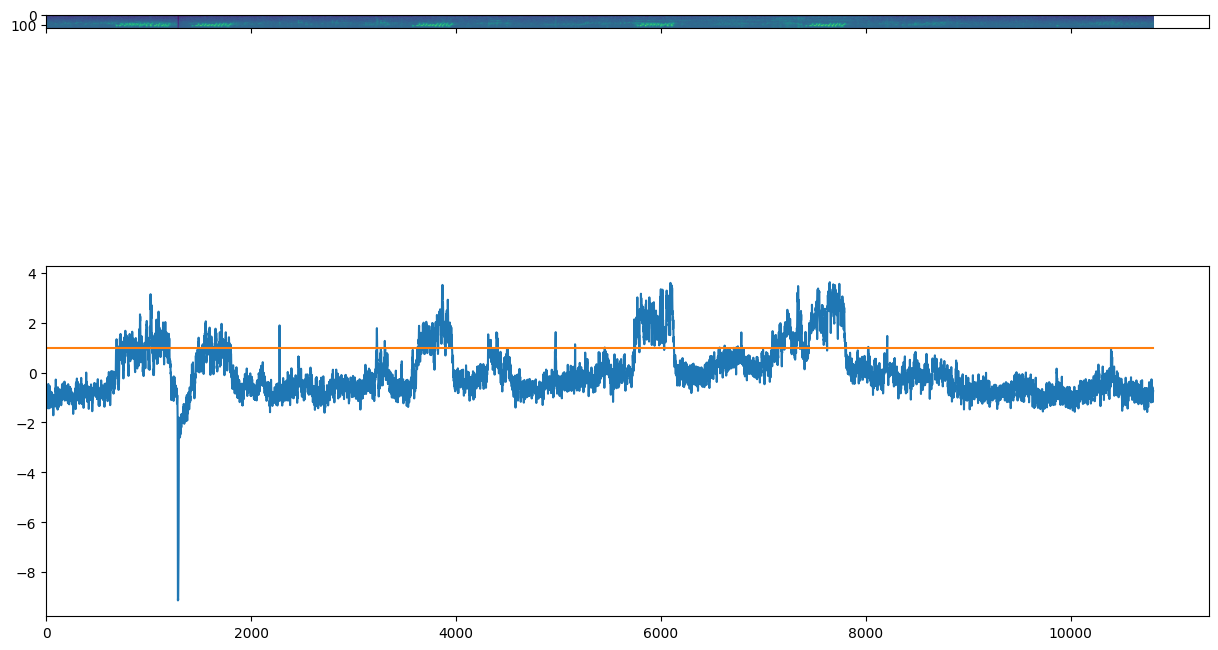

In [106]:
dat = X.detach().numpy()[0]
dat = (dat-dat.mean())/dat.std()

f, (ax1, ax2) = plt.subplots(figsize=(15,10), nrows=2, sharex=True)
ax1.imshow(dat)
datsum=dat.sum(axis=0)
ax2.plot((datsum-datsum.mean())/datsum.std())
ax2.plot([0, dat.shape[1]], [1, 1])
plt.show()

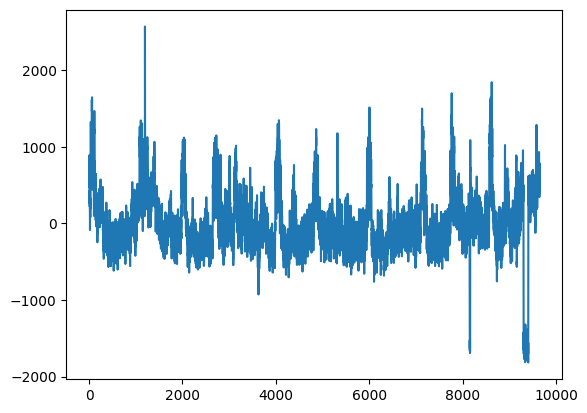

In [68]:
plt

In [ ]:
# Define model and loss criterion
model = CNN_RNN(NUM_CATEGORIES, 32, 64, 1)
criterion = nn.CrossEntropyLoss()

# Train the model
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [ ]:
X, y = next(iter(dataloader))

In [ ]:
optimizer.zero_grad()

outputs = model(X)

In [ ]:
loss = criterion(outputs, y)

In [ ]:
loss.backward()

In [ ]:
optimizer.step()